In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0,'src/')
import acs5
import nyserda_acs
import prices
import project_sunroof
import nyserda
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import recall_score

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/


%matplotlib inline

In [2]:
raw_data = nyserda_acs.merging_data()
raw_data=raw_data[raw_data['households']>0]

In [3]:
raw_data.shape

(4831, 157)

## Weights

In [4]:
#Duplicate positive rows
duplic = raw_data.loc[raw_data['Project_yes']==1,:]
duplic.loc[:,'Project_yes'] =0
duplic.loc[:,'Duplicate'] = 'Yes'
duplic.loc[:,'weight'] = (duplic.loc[:,'households']-duplic.loc[:,'Project_Number'])
duplic=duplic[duplic['weight']>0]
#Creating weights in old data
raw_data.loc[raw_data['Project_yes'] == 1, 'weight'] = raw_data['Project_Number']
raw_data.loc[raw_data['Project_yes'] == 0, 'weight'] = raw_data['households']
raw_data['Duplicate']='No'
#Merging data 
#Concatenating
all_data = raw_data.append(duplic, ignore_index=True)

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [5]:
all_data.shape

(6022, 159)

In [6]:
raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

7262279L

In [7]:
raw_data['Project_Number'].sum(axis=None, skipna=True, level=None, numeric_only=None)/raw_data['households'].sum(axis=None, skipna=True, level=None, numeric_only=None)

0.010750482045649858

## Columns

In [8]:
all_columns = list(all_data.columns)

In [9]:
len(all_columns)

159

In [10]:
acs= acs5.Get_census_data()
acs_data = acs.get_acs_all()

In [11]:
acs_percent_variables = acs.education_percent + acs.other_households + acs.units_percent + acs.heating_percent + acs.rooms_percent

## More complex model

In [12]:
acs_percent_variables.append('Project_yes')
acs_percent_variables.append('Mean_price')
acs_percent_variables.append('Var_price')
acs_percent_variables.append('percent_qualified')
acs_percent_variables.append('yearly_sunlight_kwh_total')
acs_percent_variables.append('number_of_panels_median')
acs_percent_variables.append('kw_median')
acs_percent_variables.append('weight')
acs_percent_variables.append('Duplicate')
df=raw_data[acs_percent_variables]
df.describe()

,Percent_Less_9th,Percent_12th_no_dip,Percent_HighSchool,Percent_Some_college,Percent_Associate,Percent_Bachelors,Percent_Graduate,Percent_more_than_hs,Avg_hh_size,Median_age,...,Percent_9_more_rooms,median_rooms,Project_yes,Mean_price,Var_price,percent_qualified,yearly_sunlight_kwh_total,number_of_panels_median,kw_median,weight
count,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4831.000000,4825.000000,4824.000000,...,4831.000000,4788.000000,4831.000000,4831.000000,4831.000000,3739.000000,3.739000e+03,3739.000000,3739.000000,4831.000000
mean,0.067086,0.080560,0.275853,0.165348,0.086049,0.185672,0.139433,0.576501,2.713188,38.942123,...,0.094757,5.211863,0.247154,29.261230,211.348431,74.146273,9.249323e+06,35.810110,8.952527,1106.759677
std,0.066355,0.056599,0.099750,0.055167,0.041968,0.094119,0.107784,0.164563,0.554915,7.057367,...,0.090909,1.227910,0.431402,4.082159,107.281626,13.161878,1.175220e+07,77.203298,19.300824,904.993411
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.030000,11.300000,...,0.000000,1.300000,0.000000,18.309167,95.470254,21.212121,2.178341e+03,8.000000,2.000000,1.000000
25%,0.020387,0.037663,0.215810,0.130533,0.056277,0.115651,0.061744,0.458327,2.350000,34.000000,...,0.028009,4.100000,0.000000,25.463787,170.939219,66.218202,2.905493e+06,20.000000,5.000000,298.500000
50%,0.043080,0.068670,0.282483,0.165488,0.083572,0.171992,0.110048,0.570190,2.640000,39.400000,...,0.074373,5.400000,0.000000,30.932676,188.915562,75.939850,4.895547e+06,25.000000,6.250000,1065.000000
75%,0.094349,0.110509,0.344857,0.198129,0.112512,0.239580,0.185739,0.686537,3.030000,43.800000,...,0.134913,6.100000,0.000000,30.932676,195.928370,83.643871,1.175304e+07,31.000000,7.750000,1621.000000
max,0.445956,0.400000,0.793103,1.000000,1.000000,1.000000,1.000000,1.000000,6.270000,82.000000,...,1.000000,8.500000,1.000000,35.571604,477.108098,100.000000,1.720241e+08,3980.000000,995.000000,8674.000000


In [13]:
df.shape

(4831, 48)

In [14]:
df1=df.dropna()
y=df1['Project_yes']
weights=df1['weight']
features=df1.drop(['Project_yes', 'weight','Duplicate'], axis=1)

In [15]:
features.shape

(3702, 45)

In [16]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

# define scoring function 
def custom_auc(ground_truth, predictions):
    # I need only one column of predictions["0" and "1"]. You can get an error here
    # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [17]:
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(features, y, weights, test_size=0.3, random_state=42)

In [18]:
model = GradientBoostingClassifier()
search = GridSearchCV(model, param_grid = {'n_estimators' : [50000], 'subsample' :[0.8],
                                           'max_depth': [2,3,4,5], 'learning_rate' : [0.001]}, 
                     scoring=my_auc, fit_params={'sample_weight': weights_train}, n_jobs=1, iid=True, refit=True, 
             cv=None, verbose=5, pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)

In [19]:
fitted = search.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=2 
[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.647802, total= 3.7min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.672386, total= 3.6min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.4min remaining:    0.0s


[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=2, score=0.668607, total= 3.4min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.9min remaining:    0.0s


[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=3, score=0.629297, total= 5.1min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.0min remaining:    0.0s


[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=3, score=0.649409, total= 5.2min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=3 
[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=3, score=0.665169, total= 5.4min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.628838, total= 7.3min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.634687, total= 7.3min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=4 
[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=4, score=0.660745, total= 7.2min
[CV] n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=5 
[CV]  n_estimators=50000, subsample=0.8, learning_rate=0.001, max_depth=5, score=0.622260, total= 9.3min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 77.7min finished


In [20]:
fitted.score(X_test, y_test)

0.64761589322734581

In [21]:
recall_score(y_test, fitted.predict(X_test))

0.063218390804597707

In [22]:
fitted.best_params_

{'learning_rate': 0.001,
 'max_depth': 2,
 'n_estimators': 50000,
 'subsample': 0.8}

In [23]:
# Adding results to orginal Data Frames
df1['result']=fitted.predict_proba(features)[:,1]

/Users/mariamendieta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
np.mean(df1['result'])

0.04528510383506863

## ROC Curve

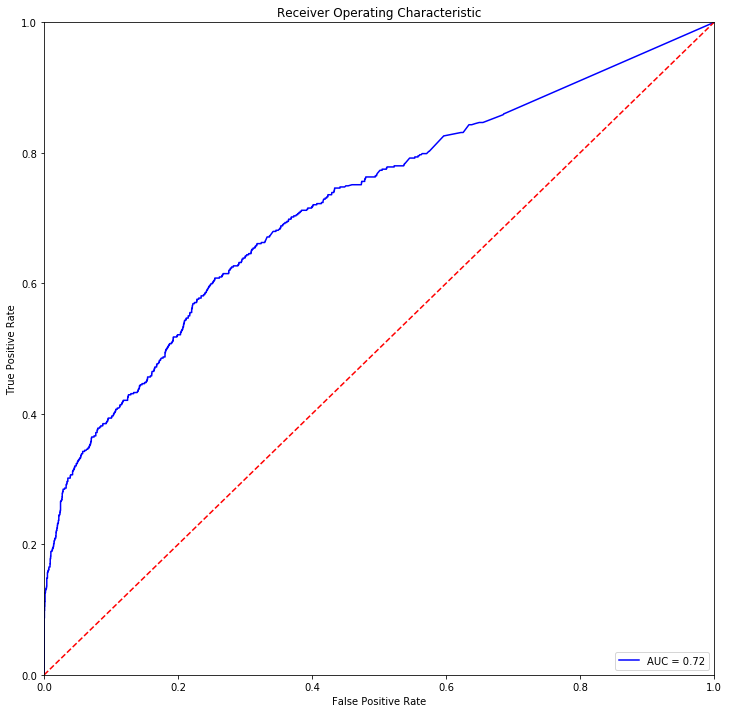

In [30]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = fitted.predict_proba(features)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, probs)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('Receiver Operating Characteristic')
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
fig.savefig('roc_sep8.png')
plt.show()


## Feature importance

In [26]:
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5)

In [27]:
fitted = model.fit(features, y, sample_weight=weights)

In [28]:
fitted.feature_importances_

array([ 0.00862334,  0.00282332,  0.00774897,  0.00552722,  0.14844306,
        0.00452671,  0.00389664,  0.01065533,  0.00360515,  0.00269414,
        0.0047974 ,  0.0150214 ,  0.03468962,  0.00379614,  0.00880067,
        0.00354424,  0.0027018 ,  0.00325662,  0.00193771,  0.01713702,
        0.08150712,  0.01348383,  0.00288836,  0.04566142,  0.01293529,
        0.06248446,  0.00393476,  0.00562186,  0.00406406,  0.00120583,
        0.01220964,  0.01215467,  0.0079636 ,  0.0318598 ,  0.02823376,
        0.03072102,  0.02161431,  0.1152269 ,  0.09103979,  0.00872632,
        0.00669862,  0.00143163,  0.09883615,  0.0016889 ,  0.0035814 ])

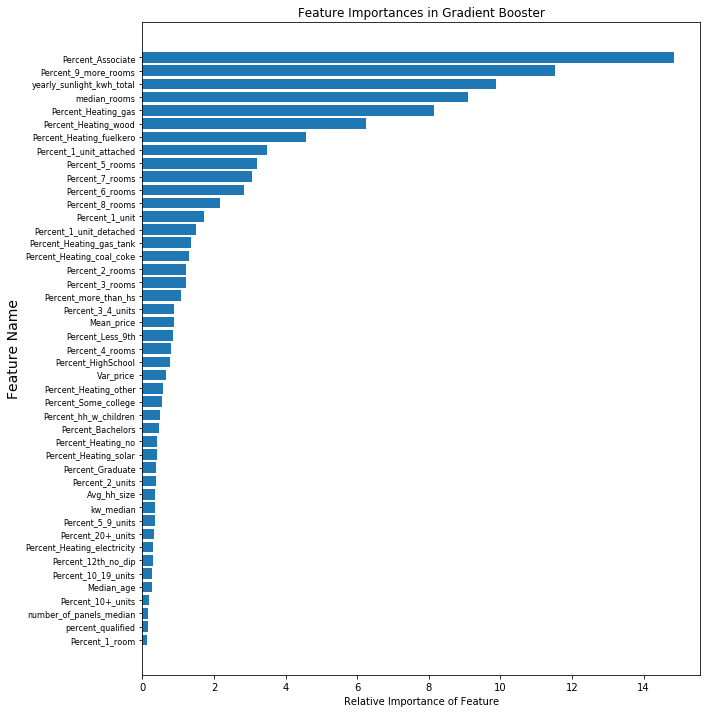

In [29]:
fitted.feature_importances_
feature_importances = 100*fitted.feature_importances_ / np.sum(fitted.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, list(features.columns), range(len(features.columns)))))

width = 0.8

idx = np.arange(len(features.columns))

fig, ax = plt.subplots(figsize=(10,12))
ax.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names, fontsize=8)

ax.set_title("Feature Importances in Gradient Booster")
ax.set_xlabel('Relative Importance of Feature', fontsize=10)
ax.set_ylabel('Feature Name', fontsize=14)
fig.savefig('feat_imp_sep8.png')

## Boosting Stages

In [18]:
N_ESTIMATORS =50000

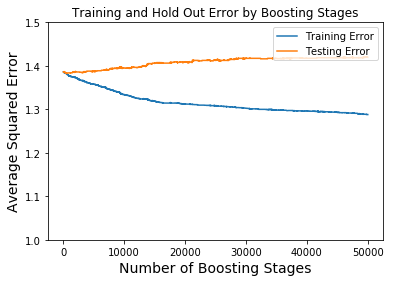

In [27]:
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS,max_depth=2, learning_rate=0.01, subsample=0.8)
model.fit(X_train, y_train, sample_weight=weights_train)

train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
plt.ylim([1, 1.5])

plt.savefig('training-and-testing-error.png', bbox_inches='tight')

In [23]:
model.staged_predict?